# Tweet Sentiment Analysis Project, Part II

## Creating the Models

## By Jarrod Mautz



## Importing libraries

In [1]:
import os
import string
import numpy as np
import pandas as pd
import joblib
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

<br>

## Setting wd and setting path for datafile to explore

Manually assigned sentiment for each exported tweet.

In [2]:
projDir = '/Users/jarrodmautz/Documents/Python Projects/Sentiment Project'
datafile= os.path.join(projDir,'manual_sentiment_trainingTweets.csv')


## Function to fit, predict, and output performance metrics for a classifier model.


In [3]:
# Fitting model and scoring
def classifier_model(X_train, y_train, X_test, y_test, model='GaussianNB', save=False, **kwargs):
    '''
    Fits, saves, predicts, outputs performance for select classification model out of 'KNN', 'SVC_poly’, ‘GaussianNB’, ‘MultinomialNB’, ‘tree', and 'forest'

    inputs:
        X_train -> nd array. X train values
        y_train -> 1d array. y train values
        X_test -> nd array. X test values
        y_test -> 1d array. y test values.
        model -> specify a model, LogReg by default. Enter string value from the above choice of models.
        save -> boolean, False by default. Enter True if you want to pickle the model
        
    output:
        y_pred -> mod.predict(X_test)
        y_score -> mod.predict_proba(X_test)
        Performance -> pd.Series() object containing metrics
        cm -> confusion matrix
    '''
 
    # Instantiating model
    mod = eval(model)(**kwargs)
    
    # Fitting models
    mod.fit(X_train, y_train)
 
    # Pickle the model if the user chooses
    if save == True:
        joblib.dump(value=mod, filename=os.path.join(projDir, str(model)+'.pickle'))
 
    # Model evaluation
    y_pred = mod.predict(X_test)
    
    # Get y_score for data visualization of metrics later
    y_score = mod.predict_proba(X_test)
    
    # Get metrics and put into a series
    precision,recall,f_score,_ = score(y_test, y_pred, average="weighted")
    perf = [precision, recall, f_score]
    performance = pd.Series(perf, index=['precision','recall','f1_score'])
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return y_pred, y_score, performance, cm

## Function to clean tweet

In [4]:
def cleaning_text(text):
    
    #nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('english')
    ps = nltk.PorterStemmer()
    
    #getting rid of punctuaction
    text  = "".join([word.lower() for word in text if word not in string.punctuation]) 
    
    #getting rid of numbers and other chars  
    text = re.sub('[0-9]+', '', text)
    text = re.sub("(@[A-Za-z0-9]+) | ([^0-9A-Za-z \t])", " ", text) 
    
    #tokenizing the words in a sentence (splitting based off white-space)
    text = re.split('\W+', text)
    
    #after tokenized remove stopwords from sentence.
    text = [word for word in text if word not in stopwords]
    
    #use a porterstemmer on the text
    text = [ps.stem(word) for word in text]
    
    #untokenize the text and join the sentence together
    cleaned_text = " ".join(text)
    
    return cleaned_text

## Import the dataset

In [5]:
# Reading in the data
dataset = pd.read_csv(datafile)
#print(dataset.loc[:,'Text'])

## Clean the Text column containing tweets

In [6]:
# Cleaning the data    
dataset['Text'] = dataset['Text'].apply(lambda X: cleaning_text(X))
dataset['Text'].head()

0    eth break ath fine bearbingo bearmarket nft nf...
1     bitcoin price metric suggest sept äô pump mar...
2                                 tradewar bitcoin üëä
3    dca live bitcoin ethereum fed benjamin cowen i...
4     link chainlink btc bitcoin atom cosmo popular...
Name: Text, dtype: object

## Set independent and dependent variable

In [7]:
X = dataset.loc[:, 'Text']
y = dataset.loc[:, 'Sentiment']

## # of each sentiment value

In [8]:
sentiment_counts = pd.DataFrame(np.array([y]).T, columns = ['encoded_values']).value_counts()
print(sentiment_counts)

encoded_values
 0                358
 1                129
-1                 74
dtype: int64


<br>

Well, looks like our dataset is imbalaced we will revisit this issue later.

<br>

# Bi-Gram TF-IDF Vectorizer


Machine learning algorithms expect the data to be numerical such as a 2-dimensional array with rows as instances and columns as features. The problem is that the data is in the form of text, and computers nor machine learning algorithm understand text. Therefore, that text needs to be transformed into a vector first. The process of transforming text into a vector is commonly referred to as text vectorization. As such, it is a fundemental step in Natural Language Processing. 

Term frequency-inverse document frequency is a text vectorizer that transforms the text into a usable vector for our algorithms. It combines 2 concepts, Term Frequency (TF) and Document Frequency (DF). Essentially, it gives the more rare words higher weights and gives common words lower weights. 

One of the downsides of this is TF-IDF Vectorizers do not care about sequence, nor do they capture semantics well. We hope to remedy this somewhat with our Bi-Gram data.

N-grams analyses are often used to see which words often show up together. Its common when using n-gram data to investigate combinations of two words or three words, i.e., Bigrams/Trigrams.

In [9]:
# Bi-Gram & TF-IDF Vectorizer 
tfidf = tf(sublinear_tf=True, ngram_range=(1,2), max_features=5500, smooth_idf=True)
X = tfidf.fit_transform(X).toarray()

lets reduce the number of total features, in order to reduce number of insignificant words/word-pairings in our corpus

First we print out the length of X[0] to find total number of features in X. Then choose number we would like out of total and plug the number into `max_features=` parameter above.

In [10]:
#outputs number of words in vectorizer
#print(len(X[0]))
#outputs -> 7906 words in X

<br>

## Splitting our dataset into training and testing data

We need to split our dataset into a 75-25 split. One for training and one set for testing.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

<br>

## Balancing training dataset

Above we can see we greatly oversampled neutral and positive tweets relative to negative ones. To balance this we will use an oversampling technique, SMOTE, from the imblearn library. 


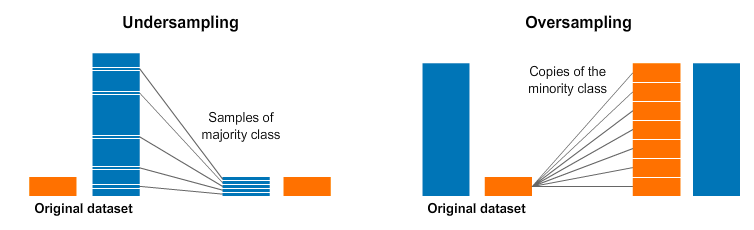

**Balancing is applied only to the training set** 


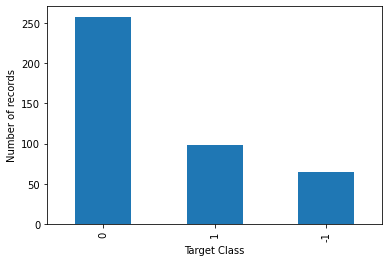

In [12]:
count = y_train.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

#### Synthetic Minority Oversampling Technique (SMOTE)

This technique generates synthetic data for the minority class.

SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

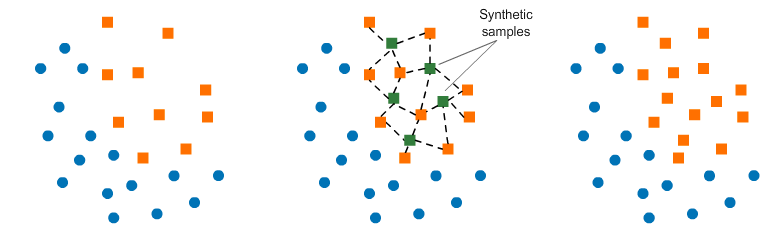

In [13]:
# Oversampled using SMOTE to balance training dataset'
from collections import Counter
from imblearn.over_sampling import SMOTE

over_sampler = SMOTE(k_neighbors=3, random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)

print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 258, -1: 258, 1: 258})
Testing target statistics: Counter({0: 100, 1: 31, -1: 10})


<br>

# Executing different classification models 

Now our data is finally set up to run through our function we made above.

In [14]:
# Classification model execution
KNN, KNN_score, KNN_perf, KNN_cm = classifier_model(X_res, y_res, X_test, y_test, model='KNeighborsClassifier') 

svc_poly, svc_poly_score, svc_poly_perf, svc_poly_cm = classifier_model(X_res, y_res, X_test, y_test, model='SVC', kernel='poly', probability=True, degree=3, C=1, random_state=42)

GNB, GNB_score, GNB_perf, GNB_cm = classifier_model(X_res, y_res, X_test, y_test, model='GaussianNB')

MNB, MNB_score, MNB_perf, MNB_cm = classifier_model(X_res, y_res, X_test, y_test, model='MultinomialNB')
 
tree, tree_score, tree_perf, tree_cm = classifier_model(X_res, y_res, X_test, y_test, model='DecisionTreeClassifier', criterion='entropy', random_state=42)

forest, forest_score, forest_perf, forest_cm = classifier_model(X_res, y_res, X_test, y_test, model='RandomForestClassifier', n_estimators=40, criterion='entropy',  random_state=42)

<br>

## Combining all the performance data together

We can now take our predictions and our y_test and we can begin to display different performance metrics for each.

In [15]:
# Join every model's performance into one dataframe
performance_all_models = pd.concat([KNN_perf, svc_poly_perf, GNB_perf, MNB_perf, tree_perf, forest_perf], axis = 1).T

# Create the index
performance_all_models["Models"] = ['KNN', 'SVC_Poly', 'GaussianNB', 'MultinomialNB', 'Tree', 'Forest']
performance_all_models.set_index('Models', inplace=True)

print(performance_all_models)

               precision    recall  f1_score
Models                                      
KNN             0.798286  0.304965  0.328242
SVC_Poly        0.705765  0.730496  0.669822
GaussianNB      0.676707  0.659574  0.662042
MultinomialNB   0.796369  0.659574  0.693631
Tree            0.667955  0.652482  0.659981
Forest          0.716676  0.744681  0.682156


<br>

## Classification reports for top 2 models

In [16]:
target_names = ["negative: -1", "neutral: 0", "positive: 1"]

In [17]:
print('\n\n Classification Report: Multinomial Naive Bayes\n')
print(classification_report(y_test, MNB, target_names=target_names))



 Classification Report: Multinomial Naive Bayes

              precision    recall  f1-score   support

negative: -1       0.24      0.70      0.36        10
  neutral: 0       0.94      0.63      0.75       100
 positive: 1       0.51      0.74      0.61        31

    accuracy                           0.66       141
   macro avg       0.56      0.69      0.57       141
weighted avg       0.80      0.66      0.69       141



In [18]:
print('\n\n Classification Report: Random Forest\n')
print(classification_report(y_test, forest, target_names=target_names))



 Classification Report: Random Forest

              precision    recall  f1-score   support

negative: -1       0.50      0.10      0.17        10
  neutral: 0       0.75      0.98      0.85       100
 positive: 1       0.67      0.19      0.30        31

    accuracy                           0.74       141
   macro avg       0.64      0.42      0.44       141
weighted avg       0.72      0.74      0.68       141



<br>

## Confusion Matrixies for top 2 models

In [19]:
print('\n\n Confusion Matrix: Multinomial Naive Bayes\n')
print(MNB_cm)



 Confusion Matrix: Multinomial Naive Bayes

[[ 7  0  3]
 [18 63 19]
 [ 4  4 23]]


In [20]:
print('\n\n Confusion Matrix: Random Forest \n')
print(forest_cm)



 Confusion Matrix: Random Forest 

[[ 1  8  1]
 [ 0 98  2]
 [ 1 24  6]]


<br>

## Top 2 Models Visualization

In [21]:
from scikitplot.metrics import plot_roc

#### Graphes for Random Forest

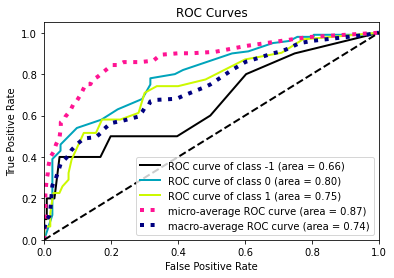

In [22]:
# Plot metrics 
plot_roc(y_test, forest_score)
plt.show()

#### Graphs for MultinomialNB

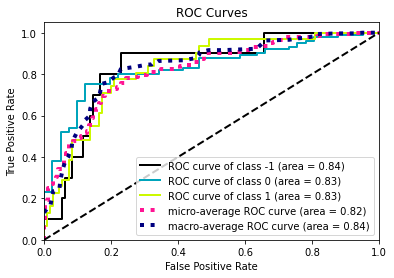

In [23]:
plot_roc(y_test, MNB_score)
plt.show()